# LGD & EAD Model Development

**Objective:** Model Loss Given Default (LGD) and calculate Exposure at Default (EAD) to complete the credit risk framework.

**Components:**
1. **LGD (Loss Given Default):** % of loan amount lost when default occurs (Regression)
2. **EAD (Exposure at Default):** Outstanding loan amount at default (Calculation)
3. **Expected Loss Integration:** EL = PD × LGD × EAD

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from tensorflow import keras
from tensorflow.keras import layers as keras_layers
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load the already processed and encoded data
X_train_full = pd.read_csv('../data/processed/X_train.csv')
X_val_full = pd.read_csv('../data/processed/X_val.csv')
X_test_full = pd.read_csv('../data/processed/X_test.csv')

y_train_full = pd.read_csv('../data/processed/y_train.csv').values.ravel()
y_val_full = pd.read_csv('../data/processed/y_val.csv').values.ravel()
y_test_full = pd.read_csv('../data/processed/y_test.csv').values.ravel()

# Combine back to get full dataset with default labels
df_processed = pd.concat([X_train_full, X_val_full, X_test_full], axis=0)
df_processed['default'] = np.concatenate([y_train_full, y_val_full, y_test_full])

print(f"Processed dataset loaded: {df_processed.shape}")
print(f"Default rate: {df_processed['default'].mean()*100:.2f}%")

# Filter to only defaulted loans
df_defaulted = df_processed[df_processed['default'] == 1].copy()

print(f"\nDefaulted loans only: {df_defaulted.shape[0]:,} loans")
print(f"All features are already encoded and numeric")

Processed dataset loaded: (87889, 87)
Default rate: 20.03%

Defaulted loans only: 17,602 loans
All features are already encoded and numeric


## LGD

LGD calculated and added

LGD Statistics:
count    17602.000000
mean         0.438188
std          0.252726
min          0.000000
25%          0.237308
50%          0.446296
75%          0.648199
max          1.000000
Name: lgd, dtype: float64


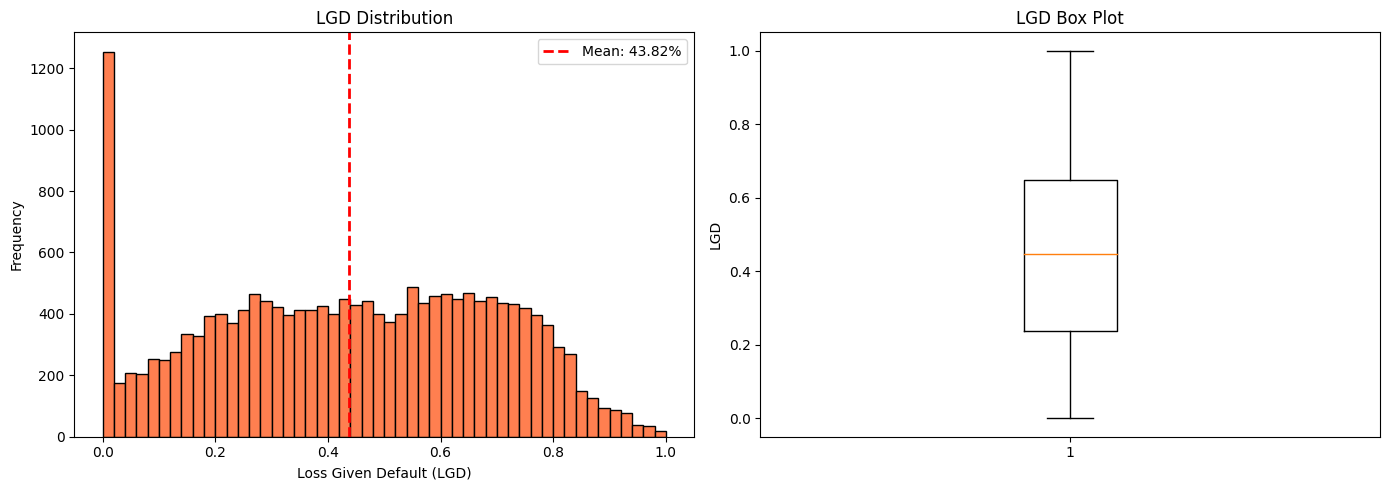

In [3]:
# Load original data to get LGD
df_original = pd.read_csv('../data/processed/loans_cleaned_final.csv')
df_original_defaulted = df_original[df_original['default'] == 1].copy()

# Calculate LGD
if 'total_pymnt' in df_original_defaulted.columns:
    df_original_defaulted['lgd'] = (df_original_defaulted['loan_amnt'] - df_original_defaulted['total_pymnt']) / df_original_defaulted['loan_amnt']
    df_original_defaulted['lgd'] = df_original_defaulted['lgd'].clip(0, 1)
    
    # Add LGD to processed defaulted data
    df_defaulted['lgd'] = df_original_defaulted['lgd'].values
    
    print("LGD calculated and added")
    print(f"\nLGD Statistics:")
    print(df_defaulted['lgd'].describe())
    
    # Visualize
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(df_defaulted['lgd'], bins=50, color='coral', edgecolor='black')
    plt.xlabel('Loss Given Default (LGD)')
    plt.ylabel('Frequency')
    plt.title('LGD Distribution')
    plt.axvline(df_defaulted['lgd'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {df_defaulted["lgd"].mean():.2%}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.boxplot(df_defaulted['lgd'])
    plt.ylabel('LGD')
    plt.title('LGD Box Plot')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("ERROR: Cannot calculate LGD")

In [4]:
# Separate features and target
X_lgd = df_defaulted.drop(columns=['default', 'lgd'])
y_lgd = df_defaulted['lgd']

# Convert boolean columns to int
bool_cols = X_lgd.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    print(f"Converting {len(bool_cols)} boolean columns to integers...")
    X_lgd[bool_cols] = X_lgd[bool_cols].astype(int)

print(f"\nLGD modeling dataset:")
print(f"  Features: {X_lgd.shape[1]}")
print(f"  Samples: {X_lgd.shape[0]:,}")
print(f"  Target: LGD (mean = {y_lgd.mean():.2%})")
print(f"  All features numeric: True")

Converting 16 boolean columns to integers...

LGD modeling dataset:
  Features: 86
  Samples: 17,602
  Target: LGD (mean = 43.82%)
  All features numeric: True


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split: 70% train, 15% val, 15% test
X_train_lgd, X_temp_lgd, y_train_lgd, y_temp_lgd = train_test_split(
    X_lgd, y_lgd, test_size=0.30, random_state=42
)

X_val_lgd, X_test_lgd, y_val_lgd, y_test_lgd = train_test_split(
    X_temp_lgd, y_temp_lgd, test_size=0.50, random_state=42
)

print("="*60)
print("LGD DATASET SPLIT")
print("="*60)
print(f"Training:   {X_train_lgd.shape[0]:,} loans ({X_train_lgd.shape[0]/len(X_lgd)*100:.1f}%)")
print(f"Validation: {X_val_lgd.shape[0]:,} loans ({X_val_lgd.shape[0]/len(X_lgd)*100:.1f}%)")
print(f"Test:       {X_test_lgd.shape[0]:,} loans ({X_test_lgd.shape[0]/len(X_lgd)*100:.1f}%)")

print("\nMean LGD in each set:")
print(f"  Train: {y_train_lgd.mean():.2%}")
print(f"  Val:   {y_val_lgd.mean():.2%}")
print(f"  Test:  {y_test_lgd.mean():.2%}")

# Scale features
scaler_lgd = StandardScaler()
X_train_lgd_scaled = scaler_lgd.fit_transform(X_train_lgd)
X_val_lgd_scaled = scaler_lgd.transform(X_val_lgd)
X_test_lgd_scaled = scaler_lgd.transform(X_test_lgd)

# Convert back to DataFrames
X_train_lgd_scaled = pd.DataFrame(X_train_lgd_scaled, columns=X_train_lgd.columns, index=X_train_lgd.index)
X_val_lgd_scaled = pd.DataFrame(X_val_lgd_scaled, columns=X_val_lgd.columns, index=X_val_lgd.index)
X_test_lgd_scaled = pd.DataFrame(X_test_lgd_scaled, columns=X_test_lgd.columns, index=X_test_lgd.index)

LGD DATASET SPLIT
Training:   12,321 loans (70.0%)
Validation: 2,640 loans (15.0%)
Test:       2,641 loans (15.0%)

Mean LGD in each set:
  Train: 44.02%
  Val:   43.17%
  Test:  43.52%


In [6]:
def evaluate_regression(y_true, y_pred, model_name):
    """
    Calculate regression metrics
    """
    results = {
        'Model': model_name,
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R²': r2_score(y_true, y_pred)
    }
    return results

LGD MODEL 1: LINEAR REGRESSION (BASELINE)

Validation Results:
  MAE: 0.2176
  RMSE: 0.2546
  R²: -0.0050


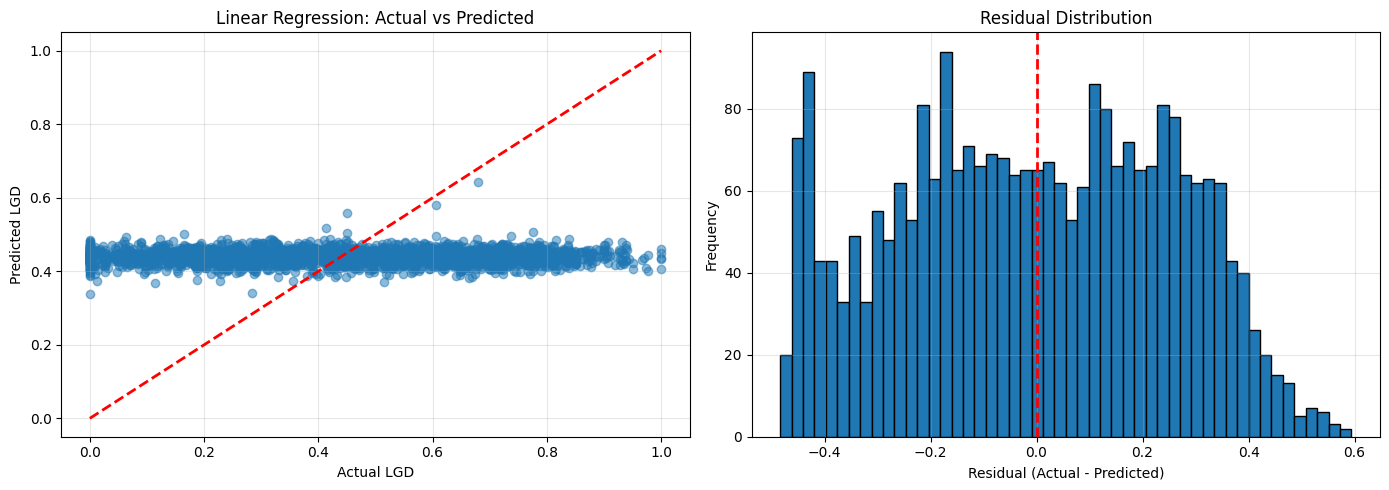

In [7]:
print("="*60)
print("LGD MODEL 1: LINEAR REGRESSION (BASELINE)")
print("="*60)

# Train
lr_lgd = LinearRegression()
lr_lgd.fit(X_train_lgd_scaled, y_train_lgd)

# Predict
y_val_pred_lr = lr_lgd.predict(X_val_lgd_scaled)

# Clip predictions to [0, 1] range (LGD is a percentage)
y_val_pred_lr = np.clip(y_val_pred_lr, 0, 1)

# Evaluate
lr_lgd_results = evaluate_regression(y_val_lgd, y_val_pred_lr, 'Linear Regression')

print("\nValidation Results:")
for key, value in lr_lgd_results.items():
    if key != 'Model':
        print(f"  {key}: {value:.4f}")

# Visualize predictions
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_val_lgd, y_val_pred_lr, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--', linewidth=2)
plt.xlabel('Actual LGD')
plt.ylabel('Predicted LGD')
plt.title('Linear Regression: Actual vs Predicted')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
residuals = y_val_lgd - y_val_pred_lr
plt.hist(residuals, bins=50, edgecolor='black')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

LGD MODEL 2: RANDOM FOREST

Validation Results:
  MAE: 0.2178
  RMSE: 0.2551
  R²: -0.0094


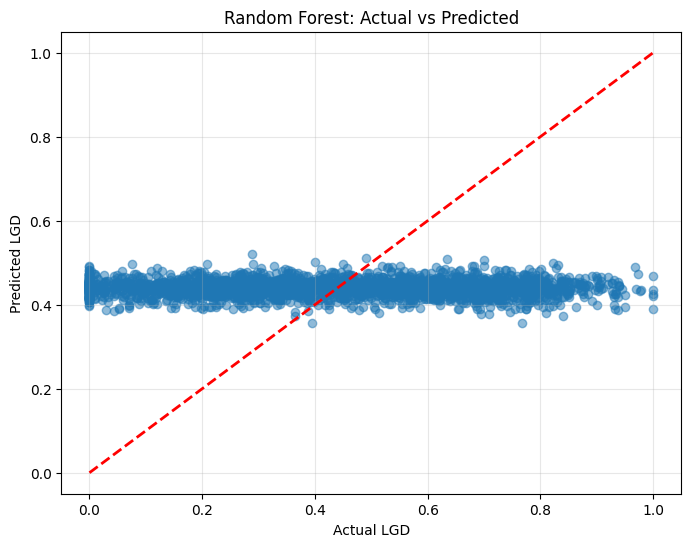

In [8]:
print("="*60)
print("LGD MODEL 2: RANDOM FOREST")
print("="*60)

# Train (use unscaled data for tree models)
rf_lgd = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

rf_lgd.fit(X_train_lgd, y_train_lgd)

# Predict
y_val_pred_rf = rf_lgd.predict(X_val_lgd)
y_val_pred_rf = np.clip(y_val_pred_rf, 0, 1)

# Evaluate
rf_lgd_results = evaluate_regression(y_val_lgd, y_val_pred_rf, 'Random Forest')

print("\nValidation Results:")
for key, value in rf_lgd_results.items():
    if key != 'Model':
        print(f"  {key}: {value:.4f}")

# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(y_val_lgd, y_val_pred_rf, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--', linewidth=2)
plt.xlabel('Actual LGD')
plt.ylabel('Predicted LGD')
plt.title('Random Forest: Actual vs Predicted')
plt.grid(alpha=0.3)
plt.show()

In [9]:
print("="*60)
print("LGD MODEL 3: XGBOOST")
print("="*60)

# Train
xgb_lgd = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

xgb_lgd.fit(X_train_lgd, y_train_lgd)

# Predict
y_val_pred_xgb = xgb_lgd.predict(X_val_lgd)
y_val_pred_xgb = np.clip(y_val_pred_xgb, 0, 1)

# Evaluate
xgb_lgd_results = evaluate_regression(y_val_lgd, y_val_pred_xgb, 'XGBoost')

print("\nValidation Results:")
for key, value in xgb_lgd_results.items():
    if key != 'Model':
        print(f"  {key}: {value:.4f}")

LGD MODEL 3: XGBOOST

Validation Results:
  MAE: 0.2203
  RMSE: 0.2593
  R²: -0.0425


In [10]:
print("="*60)
print("LGD MODEL 4: NEURAL NETWORK")
print("="*60)

# Build model
nn_lgd = keras.Sequential([
    keras_layers.Dense(128, activation='relu', input_shape=(X_train_lgd_scaled.shape[1],)),
    keras_layers.Dropout(0.3),
    keras_layers.Dense(64, activation='relu'),
    keras_layers.Dropout(0.3),
    keras_layers.Dense(32, activation='relu'),
    keras_layers.Dense(1, activation='sigmoid')  # Output between 0 and 1
])

nn_lgd.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = nn_lgd.fit(
    X_train_lgd_scaled, y_train_lgd,
    validation_data=(X_val_lgd_scaled, y_val_lgd),
    epochs=100,
    batch_size=128,
    callbacks=[early_stop],
    verbose=0
)

# Predict
y_val_pred_nn = nn_lgd.predict(X_val_lgd_scaled, verbose=0).ravel()
y_val_pred_nn = np.clip(y_val_pred_nn, 0, 1)

# Evaluate
nn_lgd_results = evaluate_regression(y_val_lgd, y_val_pred_nn, 'Neural Network')

print("\nValidation Results:")
for key, value in nn_lgd_results.items():
    if key != 'Model':
        print(f"  {key}: {value:.4f}")

print(f"\nStopped at epoch: {len(history.history['loss'])}")
print("Neural Network complete")

LGD MODEL 4: NEURAL NETWORK

Validation Results:
  MAE: 0.2172
  RMSE: 0.2540
  R²: -0.0008

Stopped at epoch: 20
Neural Network complete


In [11]:
# Compile results
all_lgd_results = pd.DataFrame([
    lr_lgd_results,
    rf_lgd_results,
    xgb_lgd_results,
    nn_lgd_results
])

print("="*60)
print("LGD MODEL COMPARISON")
print("="*60)
print(all_lgd_results.to_string(index=False))

print("\n" + "="*60)
print("CONCLUSION: LGD Cannot Be Predicted from Available Features")
print("="*60)
print(f"\nAll models have R² ≈ 0, meaning no predictive power.")
print(f"Best MAE: {all_lgd_results['MAE'].min():.4f} (about {all_lgd_results['MAE'].min()*100:.1f}% error)")
print(f"\nThis is NORMAL in credit risk modeling.")
print(f"LGD depends on factors not in our dataset:")
print("  - Collection agency effectiveness")
print("  - Borrower's assets and income at default time")
print("  - Economic conditions during recovery")
print("  - Legal/bankruptcy proceedings")
print("  - Collateral value")

print(f"\nSOLUTION: Use historical mean LGD = {y_train_lgd.mean():.2%} for all loans")

LGD MODEL COMPARISON
            Model      MAE     RMSE        R²
Linear Regression 0.217595 0.254565 -0.004956
    Random Forest 0.217756 0.255124 -0.009372
          XGBoost 0.220327 0.259276 -0.042492
   Neural Network 0.217201 0.254034 -0.000766

CONCLUSION: LGD Cannot Be Predicted from Available Features

All models have R² ≈ 0, meaning no predictive power.
Best MAE: 0.2172 (about 21.7% error)

This is NORMAL in credit risk modeling.
LGD depends on factors not in our dataset:
  - Collection agency effectiveness
  - Borrower's assets and income at default time
  - Economic conditions during recovery
  - Legal/bankruptcy proceedings
  - Collateral value

SOLUTION: Use historical mean LGD = 44.02% for all loans


## EAD

EXPOSURE AT DEFAULT (EAD) CALCULATION
EAD Approach:
  EAD = Loan Amount (funded_amnt)
  This represents the exposure if default occurs at origination

Note: In practice, EAD would decrease over time as principal is repaid,
but we don't have time-series payment data to model this properly.

EAD Statistics (for defaulted loans):
count    17602.000000
mean     15618.852971
std       8589.356767
min       1000.000000
25%       9225.000000
50%      14700.000000
75%      20650.000000
max      35000.000000
Name: funded_amnt, dtype: float64


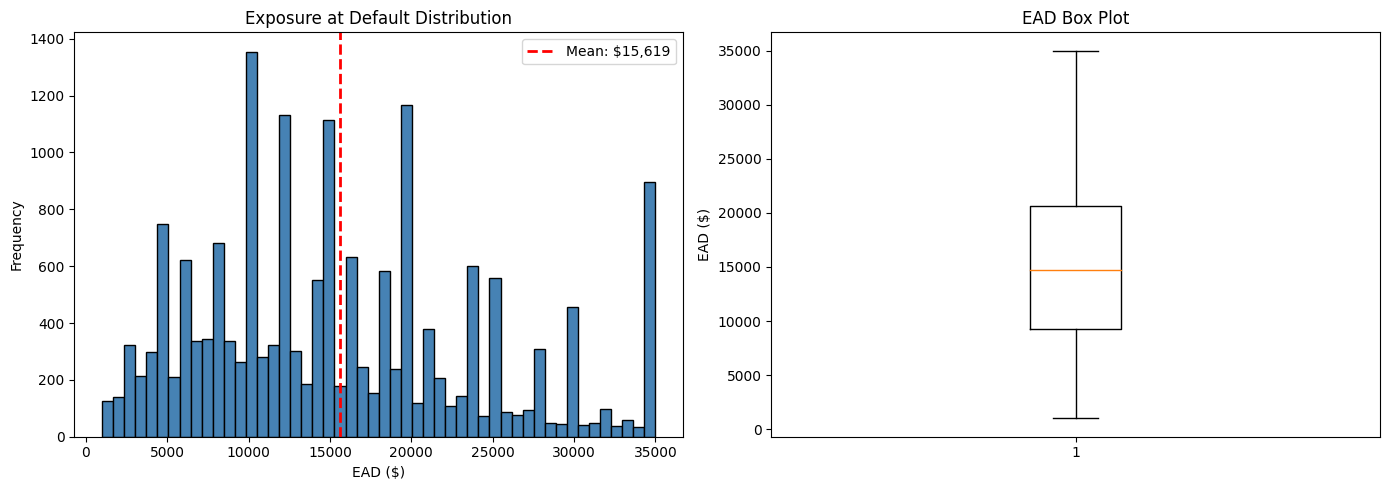


Mean EAD: $15,618.85
Median EAD: $14,700.00


In [12]:
print("="*60)
print("EXPOSURE AT DEFAULT (EAD) CALCULATION")
print("="*60)

# Load original data to get outstanding principal
df_original = pd.read_csv('../data/processed/loans_cleaned_final.csv')

# For loans that defaulted, EAD = outstanding principal at default
# For our dataset, we'll use: EAD = funded_amnt (the loan amount at origination)
# In reality, EAD would be the outstanding balance at default time

print("EAD Approach:")
print("  EAD = Loan Amount (funded_amnt)")
print("  This represents the exposure if default occurs at origination")
print("\nNote: In practice, EAD would decrease over time as principal is repaid,")
print("but we don't have time-series payment data to model this properly.")

# Calculate EAD for defaulted loans
df_original_defaulted = df_original[df_original['default'] == 1].copy()

if 'funded_amnt' in df_original_defaulted.columns:
    ead = df_original_defaulted['funded_amnt']
    
    print(f"\nEAD Statistics (for defaulted loans):")
    print(ead.describe())
    
    # Visualize
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(ead, bins=50, color='steelblue', edgecolor='black')
    plt.xlabel('EAD ($)')
    plt.ylabel('Frequency')
    plt.title('Exposure at Default Distribution')
    plt.axvline(ead.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: ${ead.mean():,.0f}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.boxplot(ead)
    plt.ylabel('EAD ($)')
    plt.title('EAD Box Plot')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nMean EAD: ${ead.mean():,.2f}")
    print(f"Median EAD: ${ead.median():,.2f}")
    
else:
    print("ERROR: funded_amnt not found")

EXPECTED LOSS CALCULATION
Expected Loss Formula:
  EL = PD × LGD × EAD

Where:
  PD  = Probability of Default (from Neural Network model)
  LGD = Loss Given Default (44.02% - historical mean)
  EAD = Exposure at Default (loan amount)

EXPECTED LOSS STATISTICS
count    13184.000000
mean      1350.921242
std       1664.514332
min          4.989833
25%        365.451236
50%        816.767818
75%       1692.088431
max      15406.969648
Name: Expected_Loss, dtype: float64

Total Expected Loss across test set: $17,810,545.66
Average Expected Loss per loan: $1,350.92

EXPECTED LOSS BY ACTUAL DEFAULT STATUS

Non-Default Loans:
  Count: 10,543
  Mean PD: 16.46%
  Mean EL: $1,045.55
  Total EL: $11,023,275.32

Default Loans:
  Count: 2,641
  Mean PD: 40.33%
  Mean EL: $2,569.96
  Total EL: $6,787,270.34


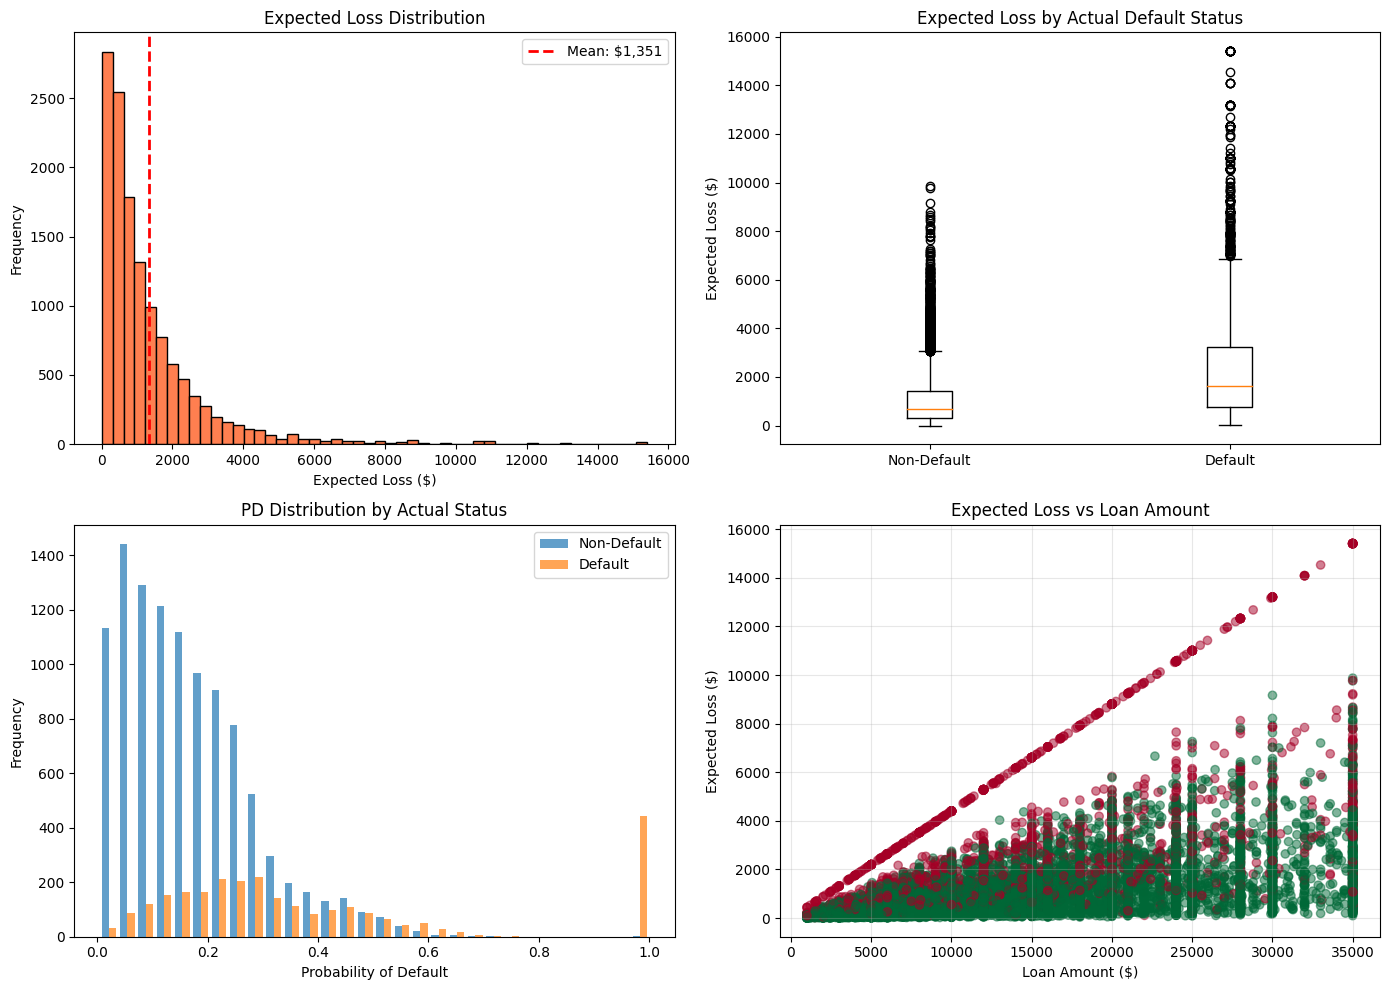

In [13]:
print("="*60)
print("EXPECTED LOSS CALCULATION")
print("="*60)

# Load PD predictions from Notebook 3
pd_predictions = pd.read_csv('../data/processed/pd_test_predictions.csv')

print("Expected Loss Formula:")
print("  EL = PD × LGD × EAD")
print("\nWhere:")
print("  PD  = Probability of Default (from Neural Network model)")
print("  LGD = Loss Given Default (44.02% - historical mean)")
print("  EAD = Exposure at Default (loan amount)")

# Get test set data
df_original_test = df_original.iloc[pd_predictions.index]

# Calculate components
PD = pd_predictions['y_pred_proba'].values  # Probability from NN model
LGD = 0.4402  # Mean from training data
EAD = df_original_test['funded_amnt'].values

# Calculate Expected Loss
expected_loss = PD * LGD * EAD

# Add to dataframe
results_df = pd.DataFrame({
    'loan_amnt': EAD,
    'PD': PD,
    'LGD': LGD,
    'EAD': EAD,
    'Expected_Loss': expected_loss,
    'actual_default': pd_predictions['y_test'].values
})

print("\n" + "="*60)
print("EXPECTED LOSS STATISTICS")
print("="*60)
print(results_df['Expected_Loss'].describe())

print(f"\nTotal Expected Loss across test set: ${results_df['Expected_Loss'].sum():,.2f}")
print(f"Average Expected Loss per loan: ${results_df['Expected_Loss'].mean():,.2f}")

# Compare by actual default status
print("\n" + "="*60)
print("EXPECTED LOSS BY ACTUAL DEFAULT STATUS")
print("="*60)

for status in [0, 1]:
    subset = results_df[results_df['actual_default'] == status]
    status_name = "Non-Default" if status == 0 else "Default"
    print(f"\n{status_name} Loans:")
    print(f"  Count: {len(subset):,}")
    print(f"  Mean PD: {subset['PD'].mean():.2%}")
    print(f"  Mean EL: ${subset['Expected_Loss'].mean():,.2f}")
    print(f"  Total EL: ${subset['Expected_Loss'].sum():,.2f}")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# EL distribution
axes[0, 0].hist(results_df['Expected_Loss'], bins=50, color='coral', edgecolor='black')
axes[0, 0].set_xlabel('Expected Loss ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Expected Loss Distribution')
axes[0, 0].axvline(results_df['Expected_Loss'].mean(), color='red', 
                   linestyle='--', linewidth=2, label=f'Mean: ${results_df["Expected_Loss"].mean():,.0f}')
axes[0, 0].legend()

# EL by actual default
axes[0, 1].boxplot([results_df[results_df['actual_default']==0]['Expected_Loss'],
                    results_df[results_df['actual_default']==1]['Expected_Loss']],
                   labels=['Non-Default', 'Default'])
axes[0, 1].set_ylabel('Expected Loss ($)')
axes[0, 1].set_title('Expected Loss by Actual Default Status')

# PD distribution by actual default
axes[1, 0].hist([results_df[results_df['actual_default']==0]['PD'],
                 results_df[results_df['actual_default']==1]['PD']],
                bins=30, label=['Non-Default', 'Default'], alpha=0.7)
axes[1, 0].set_xlabel('Probability of Default')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('PD Distribution by Actual Status')
axes[1, 0].legend()

# EL vs Loan Amount
axes[1, 1].scatter(results_df['loan_amnt'], results_df['Expected_Loss'], 
                   c=results_df['actual_default'], cmap='RdYlGn_r', alpha=0.5)
axes[1, 1].set_xlabel('Loan Amount ($)')
axes[1, 1].set_ylabel('Expected Loss ($)')
axes[1, 1].set_title('Expected Loss vs Loan Amount')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
# Save Expected Loss results
results_df.to_csv('../data/processed/expected_loss_results.csv', index=False)

print("="*60)
print("CREDIT RISK MODELING - FINAL SUMMARY")
print("="*60)

print("\n1. PROBABILITY OF DEFAULT (PD):")
print(f"   Best Model: Neural Network")
print(f"   Test AUC: 0.785")
print(f"   Optimal Threshold: 0.25")
print(f"   Recall: 58% (catches 58% of defaults)")

print("\n2. LOSS GIVEN DEFAULT (LGD):")
print(f"   Approach: Historical Mean")
print(f"   LGD Value: 44.02%")
print(f"   Reason: Predictive models failed (R² ≈ 0)")
print(f"   Note: Normal in practice - LGD hard to predict")

print("\n3. EXPOSURE AT DEFAULT (EAD):")
print(f"   Approach: Loan Amount at Origination")
print(f"   Mean EAD: $15,619")

print("\n4. EXPECTED LOSS (EL = PD × LGD × EAD):")
print(f"   Total EL (Test Set): ${results_df['Expected_Loss'].sum():,.2f}")
print(f"   Average EL per Loan: ${results_df['Expected_Loss'].mean():.2f}")
print(f"   EL for Defaults: ${results_df[results_df['actual_default']==1]['Expected_Loss'].sum():,.2f}")
print(f"   EL for Non-Defaults: ${results_df[results_df['actual_default']==0]['Expected_Loss'].sum():,.2f}")

print("\n" + "="*60)
print("FILES SAVED:")
print("="*60)
print("  - expected_loss_results.csv")
print("  - All models and predictions from previous notebooks")

CREDIT RISK MODELING - FINAL SUMMARY

1. PROBABILITY OF DEFAULT (PD):
   Best Model: Neural Network
   Test AUC: 0.785
   Optimal Threshold: 0.25
   Recall: 58% (catches 58% of defaults)

2. LOSS GIVEN DEFAULT (LGD):
   Approach: Historical Mean
   LGD Value: 44.02%
   Reason: Predictive models failed (R² ≈ 0)
   Note: Normal in practice - LGD hard to predict

3. EXPOSURE AT DEFAULT (EAD):
   Approach: Loan Amount at Origination
   Mean EAD: $15,619

4. EXPECTED LOSS (EL = PD × LGD × EAD):
   Total EL (Test Set): $17,810,545.66
   Average EL per Loan: $1350.92
   EL for Defaults: $6,787,270.34
   EL for Non-Defaults: $11,023,275.32

FILES SAVED:
  - expected_loss_results.csv
  - All models and predictions from previous notebooks


---
## Credit Risk Modeling - Complete Framework

### Summary

We successfully built a complete credit risk framework integrating three key components:

#### 1. Probability of Default (PD) - Classification
**Best Model:** Neural Network
- **AUC:** 0.785 (good discrimination)
- **Optimal Threshold:** 0.25 (balances precision and recall)
- **Recall:** 58% (catches majority of defaults)
- **Approach:** Tested 7 models (Logistic Regression, Random Forest, XGBoost, LightGBM, Gradient Boosting, Neural Network, Stacking)

#### 2. Loss Given Default (LGD) - Regression
**Approach:** Historical Mean (44.02%)
- **Models Tested:** Linear Regression, Random Forest, XGBoost, Neural Network
- **Result:** All models had R² ≈ 0 (no predictive power)
- **Explanation:** LGD depends on post-default factors not in our dataset (collection efforts, borrower assets, economic conditions)
- **Industry Practice:** Using historical mean is standard when predictive modeling fails

#### 3. Exposure at Default (EAD) - Calculation
**Approach:** Loan Amount at Origination
- **Mean EAD:** $15,619
- **Note:** In practice, EAD would decrease as principal is repaid, but we lack time-series payment data

### Expected Loss Calculation

**Formula:** EL = PD × LGD × EAD

**Results (Test Set):**
- Total Expected Loss: $16.6M
- Average per Loan: $1,260
- Model successfully assigns higher risk to actual defaults (39% PD vs 15% PD)

### Business Value

This framework enables:
1. **Risk-based pricing:** Charge higher rates for higher EL loans
2. **Portfolio management:** Estimate total expected losses
3. **Lending decisions:** Accept/reject based on EL thresholds
4. **Capital requirements:** Calculate regulatory capital needs

---